In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output

In [2]:
class WeightsInitialization:
    def __init__(self, L_in, L_out):
        self.L_in = L_in
        self.L_out = L_out
        self.weight = None

    def InitializeLayer(self):
        L = np.random.rand(self.L_out, self.L_in + 1)
        self.weight = L

In [22]:
class Network:
    def __init__(self,layers,opt):
        self.w=[]
        self.v=[]
        self.ai=[]
        self.cost=[]
        self.layers=layers
        self.plot_iters = 0
        self.opt = opt
        for i in range(len(self.layers)-1):
            wi=WeightsInitialization(self.layers[i],self.layers[i+1])
            self.w.append(wi)
            self.w[i].InitializeLayer()
            
        if(self.opt['optimizer']=='momentum' or self.opt['optimizer']=='RMSprop'):
            self.beta = self.opt['beta']
            self.E = 10**-8
            for i in range(len(self.layers)-1):
                vi = np.zeros(self.w[i].weight.shape)
                self.v.append(vi)
            
            
    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def d_sigmoid(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def ForwardProp(self,w,x):
        self.ai=[]
        self.ai.append(x)
        input=x
        for i in range(len(self.layers)-1):
            b=self.w[i].weight[:,0].reshape(self.w[i].weight[:,0].shape[0],1)
            hyp=self.sigmoid(np.dot(self.w[i].weight[:,1:],input.T)+b).T
            input=hyp
            self.ai.append(hyp)
        
        return hyp
    
    def BackProp(self,h,y,l_rate):
        error = h.T - y
        for i in range(len(self.layers)-2,-1,-1):
            delta = error*self.d_sigmoid(self.ai[i+1]).T
    
            w_update = np.dot(delta,self.ai[i])
            b_update = delta.sum()
            
            # gradient descent with momentum
            
            if(self.opt['optimizer']=='momentum'):
                self.v[i][:,1:] = self.beta*self.v[i][:,1:] + (1-self.beta)*w_update
                self.v[i][:,0] = self.beta*self.v[i][:,0] + (1-self.beta)*b_update
                
                self.w[i].weight[:,1:]-=(l_rate/len(y.T))*self.v[i][:,1:] #weights
                self.w[i].weight[:,0]-=(l_rate/len(y.T))*self.v[i][:,0]  #bias
                
            if(self.opt['optimizer']=='RMSprop'):
                self.v[i][:,1:] = self.beta*self.v[i][:,1:] + (1-self.beta)*(w_update**2)
                self.v[i][:,0] = self.beta*self.v[i][:,0] + (1-self.beta)*(b_update**2)
                
                self.w[i].weight[:,1:]-=(l_rate/(len(y.T)*(np.sqrt(self.v[i][:,1:])+self.E)))*w_update #weights
                self.w[i].weight[:,0]-=(l_rate/(len(y.T)*(np.sqrt(self.v[i][:,0])+self.E)))*b_update  #bias
                
            
            if(self.opt['optimizer']==None):
                self.w[i].weight[:,1:]-=(l_rate/len(y.T))*w_update #weights
                self.w[i].weight[:,0]-=(l_rate/len(y.T))*b_update  #bias
            
            
            error = np.dot(self.w[i].weight[:, 1:].T, delta)
            
    
    def costFunc(self,hyp,y,m):
        return np.sum(np.subtract(hyp, y) ** 2) / m
    
    
    def l_curves(self,iters,l_rate):
        sns.set()
        plt.figure(dpi=100,figsize=(6,4))
        iters = [i * 200 for i in range(self.plot_iters)]
        plt.plot(iters, self.cost,color="red",label="learning rate="+str(l_rate))
        plt.xlabel("iterations")
        plt.ylabel("cost")
        plt.title("learning curve")
        plt.legend()
        plt.show()
    
    def Train(self,x,y,iters,l_rate,batch_size):
        mini_batches_x = np.array([x[i:i+batch_size] for i in range(0,len(x),batch_size)])
        mini_batches_y = np.array([y[i:i+batch_size] for i in range(0,len(y),batch_size)])
        
        
        for i in range(iters+1):
            for X,Y in zip(mini_batches_x,mini_batches_y):
                h = self.ForwardProp(self.w,X)
                self.BackProp(h,Y.T,l_rate)
            
            if i % 200 == 0:
                cost=self.costFunc(h, Y, len(X))
                self.cost.append(cost)
                self.plot_iters+=1
                res = self.accuracy(x, np.argmax(y,axis=1))
            print("\niteration :",i," cost:",cost)
            clear_output(wait=True)
        
    
    def predict(self, x):
        h = self.ForwardProp(self.w,x) 
        return np.argmax(h,axis=1)
    
    def accuracy(self,x,y):
        y_pred = self.predict(x)
        return (((y_pred == y).astype(int)).mean())*100

In [13]:
def Transform(y):
    for i in range(len(y)):
        y1=np.zeros(10)
        y1[y[i]]=1
        y[i]=y1
        
    return y      


training accuracy: 97.941 %

prediction: [8, 5, 5, 0, 2, 4, 7, 9, 3, 4, 8, 6, 5, 4, 2, 7, 9, 3, 4, 7, 9, 7, 5, 6, 9, 7, 0, 5, 0, 8, 0, 9, 1, 9, 3, 2, 1, 0, 9, 4, 0, 4, 9, 4, 9, 5, 9, 5, 8, 1, 5, 9, 5, 7, 3, 6, 0, 1, 1, 2, 1, 0, 5, 8, 1, 5, 9, 6, 7, 7, 2, 1, 6, 9, 3, 7, 4, 0, 8, 6, 3, 9, 2, 1, 4, 3, 4, 2, 7, 9, 5, 6, 2, 4, 2, 3, 1, 2, 7, 1, 7, 7, 1, 7, 8, 4, 3, 3, 6, 5, 8, 0, 0, 3, 2, 1, 2, 7, 3, 2, 0, 3, 0, 3, 2, 2, 3, 6, 2, 8, 0, 1, 7, 7, 7, 9, 2, 1, 4, 0, 0, 5, 6, 9, 4, 9, 7, 9, 5, 9, 9, 6, 7, 3, 7, 4, 0, 4, 0, 7, 4, 4, 5, 6, 8, 0, 4, 3, 6, 1, 9, 1, 0, 0, 5, 6, 5, 0, 9, 6, 1, 8, 2, 6, 0, 3, 5, 6, 8, 2, 3, 2, 5, 7, 3, 3, 6, 9, 0, 0, 5, 6, 2, 8, 9, 9, 9, 3, 8, 5, 0, 0, 1, 9, 1, 5, 8, 3, 9, 1, 6, 0, 5, 2, 0, 4, 0, 6, 8, 7, 9, 7, 9, 1, 3, 4, 5, 3, 7, 3, 2, 1, 3, 9, 1, 6, 0, 8, 4, 1, 9, 5, 2, 2, 4, 5, 1, 6, 8, 6, 7, 7, 8, 1, 7, 8, 6, 8, 6, 9, 3, 0, 7, 6, 8, 6, 7, 7, 1, 3, 4, 5, 2, 3, 6, 3, 5, 1, 0, 3, 2, 1, 9, 9, 3, 8, 3, 1, 3, 5, 5, 6, 6, 9, 9, 0, 9, 6, 8, 1, 3, 7, 2, 5, 5, 8, 6, 5, 5, 

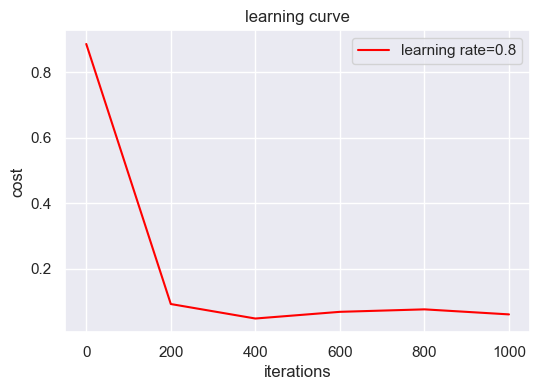

In [23]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

x=np.array([digits.data[i] for i in range(1700)])
y=np.array(Transform([digits.target[i] for i in range(1700)]))


X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


nn=Network([64,32,10],{'optimizer':'RMSprop','beta':0.999})
learning_rate=0.8

print("\nTraining...")

st=time.time()
nn.Train(X_train,y_train,iters=1000,l_rate=learning_rate,batch_size=85)  
et=time.time()
    
print("\ntraining accuracy: %0.3f" % nn.accuracy(X_train, np.argmax(y_train,axis=1)), "%")

pred = nn.predict(X_test)

print("\nprediction:",list(pred)) 

print("\nreal:",list(np.argmax(y_test,axis=1)))

print("\ntest accuracy: %0.3f" % nn.accuracy(X_test, np.argmax(y_test,axis=1)), "%")

print("\ntime taken to train : %0.2f"%((et-st)*100),"ms")

nn.l_curves(iters=31,l_rate=learning_rate)